Lending Club is a "Market Place Lender" which allows an individual to apply for a personal loan to be filled by the market, as opposed to a bank or other specialty lender.   They have grown in success and to date have closed over $3Bn in loans.    Lending Club has made loan and performance information freely available on their website. 

The data is available on the Lending Club website (https://www.lendingclub.com/info/download-data.action).   I manually downloaded the CSV files and stored them locally.   I am using only one subset of the total lending club data.  

My objectives in this project are threefold:
    i) Learn how to view, clean and manipulate large datasets;
    ii)Develop intuition for fitting estimators to the data;
    iii) What are the best predictors of borrower default? 
    iv) What rates do borrowers pay versus their other financial options?
    v) What are the best predictors of early borrower repayment? 
    vi) Start to develop a better way to predict creditworthiness of borrowers beyond the standard methods (eg, FICO); 
        a) For example, can we parse their loan purpose comments to develop a predictor of default?
        b) Can I take location information (eg, via zip codes) to get a better understanding the regional economy? 
        c) Ultimately, I would like to also use complementary external data sources to allow better prediction. 

## AS OF THE END DATE OF THE COURSE:  
A lot of time has been spent on cleaning, scrubbing, and understanding the organization of the data.   I had to generate some calculated features, and further projects include parsing the text fields.   


 

In [1]:
# load relevant libraries
#  This Workbook assumes the presence of a cleaned Lending Club file. 

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation import train_test_split
import seaborn as sns

%matplotlib inline

lcd_temp = pd.read_csv("/Users/Glenn/Documents/LendingClub/LendingClub_07-12_CLEANED.csv", parse_dates=['last_pymnt_date','issue_date',
                                                                                                        'last_credit_pull_date','last_pymnt_date','next_pymnt_date'])

In [190]:
lcd_temp = lcd_temp[pd.notnull(lcd_temp.last_pymnt_date) & pd.notnull(lcd_temp.issue_date)]
 
print lcd_temp.columns

Index([u'Unnamed: 0', u'Rent', u'Own', u'Mortgage', u'Other', u'loan_amnt', u'funded_amnt', u'term', u'int_rate', u'installment', u'grade', u'sub_grade', u'emp_length', u'home_ownership', u'annual_inc', u'verification_status', u'issue_d', u'loan_status', u'pymnt_plan', u'purpose', u'dti', u'delinq_2yrs', u'fico_range_low', u'fico_range_high', u'inq_last_6mths', u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc', u'pub_rec', u'total_acc', u'recoveries', u'last_pymnt_d', u'last_pymnt_amnt', u'next_pymnt_d', u'last_credit_pull_d', u'collections_12_mths_ex_med', u'mths_since_last_major_derog', u'last_pymnt_date', u'next_pymnt_date', u'last_credit_pull_date', u'issue_date', u'emp_length_numeric', u'clean_rates', u'clean_term', u'sub_grade_int', u'verification_status_b', u'home_ownership_int', u'pymnt_plan_bool', u'fico_interp', u'loan_status_int', u'Current', u'Delinquent', u'Default'], dtype='object')


In [191]:
lcd_temp['time_to_default'] = lcd_temp['last_pymnt_date'] - lcd_temp['issue_date']
lcd_temp['time_to_default'] = [j.days for j in lcd_temp.time_to_default]
lcd_temp['mos_to_default'] = [round(float(j/30),0) for j in lcd_temp.time_to_default]
lcd_temp[['time_to_default','mos_to_default']].head()

,time_to_default,mos_to_default
0,1127,37
1,487,16
2,913,30
3,1127,37
4,1217,40


In [192]:
lcd_temp['mos_to_default_norm'] = lcd_temp['mos_to_default']/lcd_temp['clean_term']
lcd_temp['mos_to_default_norm'] = [min(i,1) for i in lcd_temp.mos_to_default_norm]                                                                                                                

In [196]:
lcd_temp.sort(columns = 'mos_to_default_norm', inplace=True)
lcd_temp.reset_index(inplace= True, drop=True)
# lcd_temp.head(20)

In [205]:
# Default amount is size of loan if defaulted. 
lcd_temp['default_amnt'] =  lcd_temp['Default']*lcd_temp['loan_amnt']

default_pct = lcd_temp.groupby(lcd_temp.clean_term)['default_amnt'].sum()/lcd_temp.groupby(lcd_temp.clean_term)['loan_amnt'].sum()

print default_pct
lcd_temp[['default_amnt', 'Default', 'loan_amnt','mos_to_default']].head(10)

clean_term
36            0.119477
60            0.203027
dtype: float64


,default_amnt,Default,loan_amnt,mos_to_default
0,0,0,18000,0
1,0,0,10000,0
2,0,0,35000,0
3,0,0,3700,0
4,0,0,6800,0
5,0,0,8000,0
6,0,0,2000,0
7,0,0,10000,0
8,0,0,1000,0
9,4500,1,4500,0


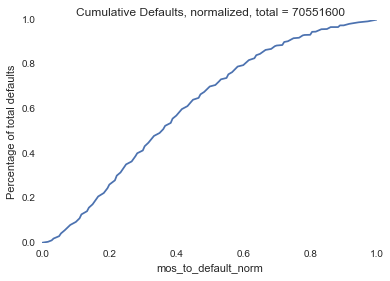

In [220]:
defaulted_df = lcd_temp[lcd_temp['Default']==1][['mos_to_default_norm','default_amnt','grade']]

defaulted_total = defaulted_df['default_amnt'].sum()
defaulted_df.sort(columns = 'mos_to_default_norm', inplace=True)
defaulted_df.reset_index(inplace=True,drop=True)
# Got this code from Stack Exchange....very useful!
cum_defaults = defaulted_df.groupby('mos_to_default_norm').default_amnt.sum().cumsum()

cum_defaults /= defaulted_total

plt.title("Cumulative Defaults, normalized, total = %d" % round(defaulted_total,0))
plt.ylabel("Percentage of total defaults")
plt.xlabel("Normalized Time")
cum_defaults.plot()

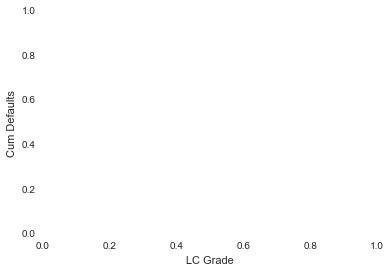

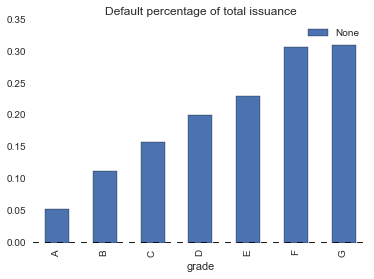

In [330]:
# Lets plot default pctage by ratings grade  

default_by_grade = defaulted_df.groupby('grade')['default_amnt'].sum()
total_issuance_by_grade = lcd_temp.groupby('grade')['loan_amnt'].sum()

# make a df out of these two series
defaults = pd.concat([total_issuance_by_grade,default_by_grade], axis=1)
defaults.columns = ('issuance','defaults')

# Default pctage = total defaults / total issuance 
defaults['cum_default_rate'] = defaults.defaults/defaults.issuance

defaults.reset_index(inplace=True)
defaults.head(7)

#plt.title()
plt.xlabel('LC Grade')
plt.ylabel('Cum Defaults')
# plt.bar(height=defaults.cum_default_rate)
defaults.plot(kind='bar', x='grade', y='cum_default_rate', title ='Default percentage of total issuance')


In [27]:
# Create df of only 36 mos loans.
lcd_36M = lcd_temp[lcd_temp.clean_term==36]
lcd_36M.reset_index(inplace = True)

# Got this code from Stack Exchange....very useful!
cum_defaults = Default_V_36M.groupby('mos_to_default').default_amnt.sum().cumsum()
# cum_defaults = cum_defaults.reindex(index=range(min(cum_defaults.index),
#                                   max(cum_defaults.index) + 1),  method='ffill')

In [30]:
lcd_36M.describe()

,index,Unnamed: 0,Rent,Own,Mortgage,Other,loan_amnt,funded_amnt,installment,annual_inc,...,home_ownership_int,pymnt_plan_bool,fico_interp,loan_status_int,Current,Delinquent,Default,time_to_default,mos_to_default,default_amnt
count,31469.000000,31469.000000,31469.000000,31469.000000,31469.000000,31469.000000,31469.000000,31469.000000,31469.000000,31465.000000,...,31469.000000,31469,31469.000000,31469.000000,31469.000000,31469.000000,31469.000000,31469.000000,31469.000000,31469.000000
mean,23046.740697,23046.740697,0.502304,0.078204,0.414948,0.004544,9537.583018,9411.224538,310.704952,67521.242401,...,0.921732,0.0001271092,715.086847,0.242302,0.878706,0.000286,0.121008,809.147796,26.576154,1139.521434
std,12657.124812,12657.124812,0.500003,0.268497,0.492721,0.067258,6311.983506,6219.059415,209.682882,64283.652631,...,0.964019,0.01127373,36.781675,0.652396,0.326474,0.016909,0.326142,337.587814,11.096038,3799.654472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500.000000,500.000000,15.670000,1896.000000,...,0.000000,False,612.000000,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000
25%,11832.000000,11832.000000,0.000000,0.000000,0.000000,0.000000,5000.000000,5000.000000,159.410000,39996.000000,...,0.000000,0,687.000000,0.000000,1.000000,0.000000,0.000000,547.000000,18.000000,0.000000
50%,24237.000000,24237.000000,1.000000,0.000000,0.000000,0.000000,8000.000000,8000.000000,260.590000,56004.000000,...,0.000000,0,712.000000,0.000000,1.000000,0.000000,0.000000,943.000000,31.000000,0.000000
75%,34335.000000,34335.000000,1.000000,0.000000,1.000000,0.000000,12000.000000,12000.000000,405.290000,80000.000000,...,2.000000,0,742.000000,0.000000,1.000000,0.000000,0.000000,1096.000000,36.000000,0.000000
max,42535.000000,42535.000000,1.000000,1.000000,1.000000,1.000000,35000.000000,35000.000000,1305.190000,6000000.000000,...,3.000000,True,827.000000,2.000000,1.000000,1.000000,1.000000,1979.000000,65.000000,35000.000000


In [85]:
# Select Features and create the feature and target dfs. 
# FICO is a log scale...eg, FICO of 700 is 10x more likely to default than 800.   So we need to transform FICO feature
import math

lcd_36M.loc[:,'fico_log'] = [math.log(j,10) for j in lcd_36M.fico_interp]
# X_Columns = ['fico_interp', 'dti','clean_rates','loan_amnt','mths_since_last_record','mths_since_last_delinq']
X_Columns = ['fico_interp']
# I used concat as performing dropna on the entire dataset would present problems.  
lcd = pd.concat([lcd_36M[X_Columns],lcd_36M['Default']],axis=1).dropna()
X = lcd[X_Columns]
y = lcd['Default']

In [86]:
# Create train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.50,random_state=123)

In [87]:
#  Calculate a logistic regression against the 2 features for now. 
# Use Cross Validation to create train, test samples from data

import sklearn
import sklearn.linear_model as lm
import sklearn.grid_search as gs

#  Run a logistic regression on the training set to predict y
logreg = lm.LogisticRegression()
logreg.fit(Xtrain, ytrain)
print logreg.coef_
print logreg.intercept_
print logreg.score(Xtest,ytest)

[[-0.00279428]]
[ -3.78580582e-06]
0.879822052749


In [32]:
# Let's try to visualize features correlated to default.
# First, take xtrain, ytrain and create two dataframes depending on default status
# train = pd.DataFrame(Xtrain, columns = X.columns)
# train['default'] = ytrain
# train_nd = train[train['default']==0]
# train_d = train[train['default']==1]
# print Xtrain.shape
# plt.figure(figsize=(12,9))

#  plt.scatter(train_nd.fico_interp, train_nd.dti, alpha= 0.75,marker='+', c= 'b')
# plt.scatter(train_d.fico_interp, train_d.dti, marker='o', edgecolors = 'r', facecolors = 'none')
# plt.legend( ('no default', 'default'), loc='upper right')

In [ ]:
#  We should use feature reduction here to select top features from total.  


In [88]:
# Create Scaled features and supply to KNN.
from sklearn import preprocessing

scaled_features = preprocessing.scale(X)

# Create new dataframes from scaled features
X_scaled = pd.DataFrame(scaled_features, columns=X.columns)
pd.scatter_matrix(wine_features, c=y, figsize=(20, 20), s=120, cmap='brg');

# Scaler applies 0 mean and unit variance:
X_scaled.describe()

,fico_interp
count,3.146900e+04
mean,-5.708005e-16
std,1.000016e+00
min,-2.802713e+00
25%,-7.636219e-01
50%,-8.392485e-02
75%,7.317117e-01
max,3.042682e+00


In [89]:
# Create scaled train and test sets
Xtrain_S, Xtest_S, ytrain_S, ytest_S = train_test_split(X_scaled,y,test_size=0.50,random_state=123)

In [90]:
#  Calculate a logistic regression against the 2 features for now. 
#  Run a logistic regression on the training set to predict y
logreg = lm.LogisticRegression()
logreg.fit(Xtrain_S, ytrain_S)
print logreg.coef_
print logreg.intercept_
print logreg.score(Xtest_S,ytest_S)

[[-0.53419457]]
[-2.074061]
0.879822052749


In [91]:
# Let's try to tune some logreg hyperparameters.   
# pipeline with scaling to select best C and penalty
# Use Cross Validation to create train, test samples from data
from sklearn.pipeline import make_pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

pipe = make_pipeline(preprocessing.StandardScaler(), lm.LogisticRegression())
C_range = 10.**np.arange(-5, 1)
penalty_options = ['l1', 'l2']

skf = StratifiedKFold(y, 3)
param_grid = dict(logisticregression__C=C_range, logisticregression__penalty=penalty_options)

grid = GridSearchCV(pipe, param_grid, cv=skf, scoring='roc_auc')
grid.fit(X, y)
print grid.best_score_
print grid.best_params_

0.63281907346
{'logisticregression__penalty': 'l2', 'logisticregression__C': 1.0000000000000001e-05}


In [96]:
#  Run a new logistic regression on the training set to predict y
logreg = lm.LogisticRegression(penalty= 'l2',C=1.0000000000000001e-05)
logreg.fit(Xtrain, ytrain)
probas = logreg.predict_proba(Xtrain)


print logreg.coef_
print logreg.intercept_
print logreg.score(Xtest,ytest)

[[-0.00279395]]
[ -3.78538526e-06]
0.879822052749


In [93]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.cross_validation import StratifiedKFold

from scipy import interp

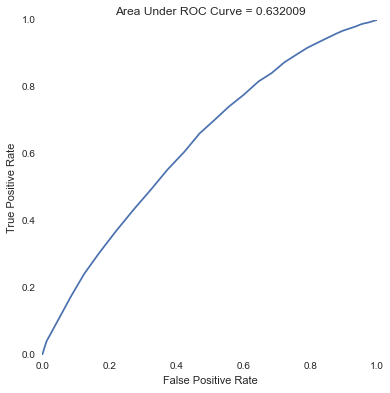

In [113]:
# Get classification probabilities from log reg 

y_probas = logreg.predict_proba(X)[:,1]

# Generate ROC Curve from y and y_probas
fpr, tpr, thresholds= roc_curve(y, y_probas)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under ROC Curve = %f' % roc_auc_score(y, y_probas))


In [ ]:
print roc_auc_score(y, y_probas)

In [ ]:
# plot ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test_binary, y_probs_binary)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

